# The process
I will first do some EDA to understand the dataset, recognize the features and labels, clean it up a bit and then apply some SK-learn algorithms to answer the questions in the pdf.

## 1) Importing necessary packages and functions

In [3]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

## 2) Reading and cleaning the dataset
The data has 54314 entries with 8 columns. The <font color=blue>reach</font> column will be dropped as it has only **NaN** values. The <font color=blue>Unnamed: 0</font> will also be dropped as it is a copy of the index. The <font color=blue>campaign_id</font> and <font color=blue>ad_id</font> columns will be converted into categories for memory efficiency in EDA. For training the model they will be hashed into integers in an array. For the <font color=blue>purchase</font>, the **NaN** values will be replaced with **0** as they indicate that no purchase has happened. While a value of **1.0** means a purchase has happened, it is not possible to compare with the 'spend' variable as prices are not indicated. The time column will be converted into an integer indicating the time (as all slots are shown equally for one hour).<br><br>
I will also create a new column called Click-through-rate (<font color=blue>CTR</font>) defined as the rate of clicks on ads divided by views of ads ([source](https://support.google.com/google-ads/answer/2615875?hl=en)).
Additionally, a <font color=blue>month</font> column will indicate the month and year of the campaign ad.


In [4]:
df=pd.read_csv('facebook_ad_hourly_v01.csv', sep=';', parse_dates = ['date'])

# dropping the first column (index) and the reach column (only nan values)
df.drop(['Unnamed: 0', 'reach'], axis=1, inplace=True)

# replacing NaN values with 0 for the purchase
df.purchase.replace(np.nan, 0, inplace=True)

# changing the id columns to categories
df['campaign_id']=df.campaign_id.astype('category')
df['ad_id']=df.ad_id.astype('category')

# create a Click-through-rate (CTR) column defined as the rate of clicks on ads divided by views of ads 
df['CTR'] = round(df.clicks / df.impressions, 2)
df.CTR.replace(np.inf, 0, inplace=True)

# create a month column
df["month"] = df.date.dt.to_period("M")

# converting time into a datetime then extracting the hour (as integer)
df['time'] = pd.to_datetime(df['time'].str.split(' ').str.get(0))
df['time'] = df.time.dt.hour

# dropping 5 columns where there was a click without an impression (I assume it's a data entry error)
print(len(df[(df.clicks > 0) & (df.impressions == 0)]))
df = df[~((df.clicks > 0) & (df.impressions == 0))]

# no more missing values
df.info()

# summary of the data
print('\n -----------------------------')
print(df.describe())

display(df.head())

5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54309 entries, 0 to 54313
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaign_id  54309 non-null  category      
 1   ad_id        54309 non-null  category      
 2   date         54309 non-null  datetime64[ns]
 3   time         54309 non-null  int64         
 4   spend        54309 non-null  float64       
 5   impressions  54309 non-null  int64         
 6   clicks       54309 non-null  int64         
 7   purchase     54309 non-null  float64       
 8   CTR          54309 non-null  float64       
 9   month        54309 non-null  period[M]     
dtypes: category(2), datetime64[ns](1), float64(3), int64(3), period[M](1)
memory usage: 3.9 MB

 -----------------------------
               time         spend   impressions        clicks      purchase  \
count  54309.000000  54309.000000  54309.000000  54309.000000  54309.000000   
mean      12.62

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase,CTR,month
0,23843490210650549,23843490222550549,2019-07-18,7,0.04,6,0,0.0,0.0,2019-07
1,23843490210650549,23843490222600549,2019-07-18,7,0.00,2,0,0.0,0.0,2019-07
2,23843490210650549,23843490222650549,2019-07-18,7,0.00,1,0,0.0,0.0,2019-07
3,23843490210650549,23843490222880549,2019-07-18,7,0.04,5,0,0.0,0.0,2019-07
4,23843490224560549,23843490225720549,2019-07-18,7,0.01,1,0,0.0,0.0,2019-07


## 3) Evaluating the features

The dataset seems to be highly asymmetric, which is usually not good news for machine learning models. From the summary above, the <font color=blue>impressions</font> range has a standard deviation of 2505 with 12204 ads having 1 view, and one single ad having 93132 views. This column will need to be rescaled before training a model on.<br>

The CTR metric is commonly used to evaluate targeted ads success. Due to the huge imbalance in this dataset, its effectiveness as a prediction label is unclear. From the table below, one notices that the highest CTRs are from ads with few impressions, with the notable common variable being the month of July on 2019. There are also some ads with CTRs higher than 1 (48 of them). I will assume that these have been clicked through several times by the same person and will convert them to 1. The purchase values are also very asymmetric with only 3% of clicked-on ads having been purchased. <br>

The 'spend' per hour is also distributed unevenly with more than half of the values near 0 (see density historgram below). As for the hour of the day, it is intuitive that there would be more impressions, clicks and purchases later in the day (see below). <br>

The features are also not indepedant (as is usually assumed for a training data). Campaigns and ads have a 1-to-many relationship and there is likely some correlation between spend and impressions. I will also not take the month/year feature into training because it is distributed over only 12 months in 3 years, rendering it useless to predict anything for months not included in this period.

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase,CTR,month
24876,23843490210650549,23843504283340549,2019-07-26,16,0.07,5,4,0.0,0.80,2019-07
34039,23843769822320549,23843769853300549,2019-10-22,18,0.05,5,4,0.0,0.80,2019-10
48209,23845069585730549,23845069958820549,2020-07-29,5,0.04,5,4,0.0,0.80,2020-07
8456,23843490210650549,23843504283100549,2019-07-29,3,0.16,4,3,0.0,0.75,2019-07
9556,23843490224560549,23843490237710549,2019-07-17,7,0.02,4,3,0.0,0.75,2019-07
14468,23843490210650549,23843490213720549,2019-07-16,18,0.07,4,3,0.0,0.75,2019-07
16048,23843490210650549,23843490212120549,2019-07-30,21,0.06,4,3,0.0,0.75,2019-07
45117,23844530214060549,23844535490680549,2020-04-21,21,0.03,4,3,0.0,0.75,2020-04
1400,23843490224560549,23843490235860549,2019-07-23,10,0.05,3,2,0.0,0.67,2019-07
2786,23843490210650549,23843490217190549,2019-07-16,14,0.02,3,2,0.0,0.67,2019-07


48 ads have been clicked on more than once by the same person.
0.23554107054079435
0.030331457160725453


<AxesSubplot:title={'center':'Number of ad-hours per campaign'}, ylabel='campaign_id'>

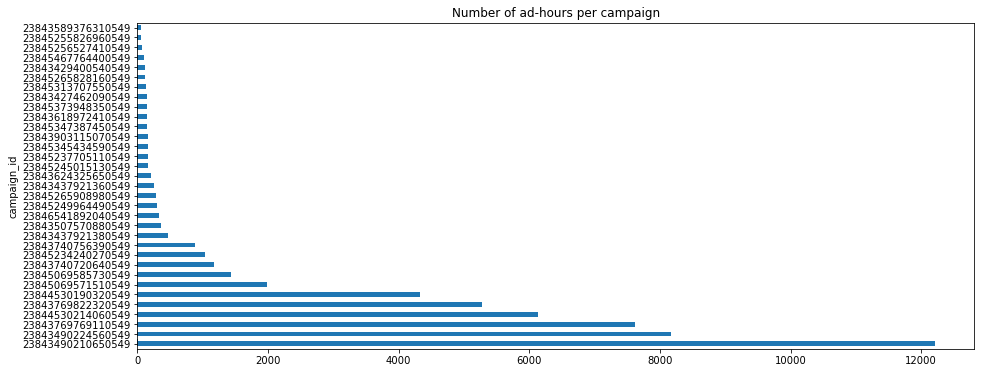

In [5]:
# displaying the 10 highest CTR ads
display(df.query('CTR<1').nlargest(10, 'CTR'))

# converting CTRs > 1 to 1
print("{} ads have been clicked on more than once by the same person.".format(len(df.query('CTR > 1'))))
df['CTR'] = df['CTR'].mask(df['CTR'] > 1, 1)

# 23.5% of ads have been clicked on
print(len(df.query('clicks > 0')) / len(df))

# 3% of clicked-on ads have been purchased
print(len(df.query('purchase > 0')) / len(df.query('clicks > 0')))

# histogram of ad spend
plt.hist(df.spend, density=True, bins=50)
plt.title('Distribution of ad spend')

df.value_counts('campaign_id').plot(kind='barh', title='Number of ad-hours per campaign', figsize=(15,6))

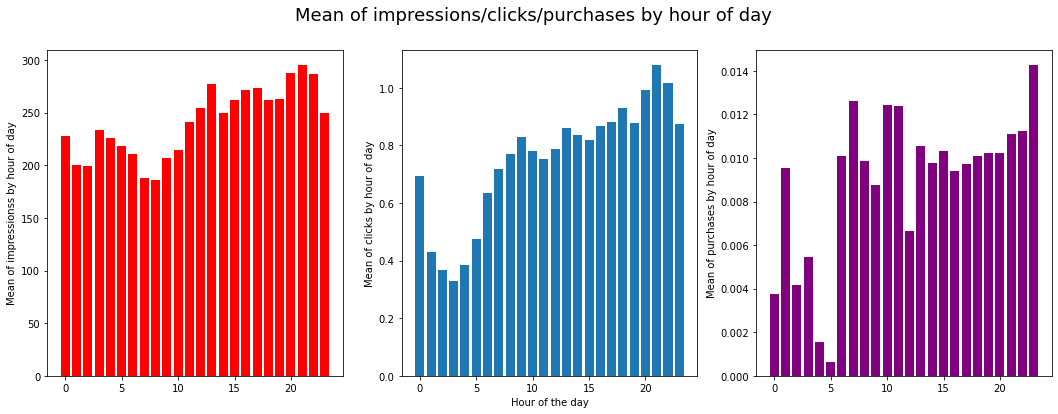

In [6]:
# understanding the influence of the hour of the day

grouped = df.groupby(['time'])[['impressions', 'clicks', 'purchase']].mean()

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
ax[0].bar(grouped.index, grouped.impressions, color='red')
ax[1].bar(grouped.index, grouped.clicks)
ax[2].bar(grouped.index, grouped.purchase, color ='purple')

fig.suptitle('Mean of impressions/clicks/purchases by hour of day', fontsize=18)
ax[0].set_ylabel("Mean of impressionss by hour of day")
ax[1].set_ylabel("Mean of clicks by hour of day")
ax[2].set_ylabel("Mean of purchases by hour of day")
ax[1].set_xlabel("Hour of the day")
plt.show()


## Feature relationships


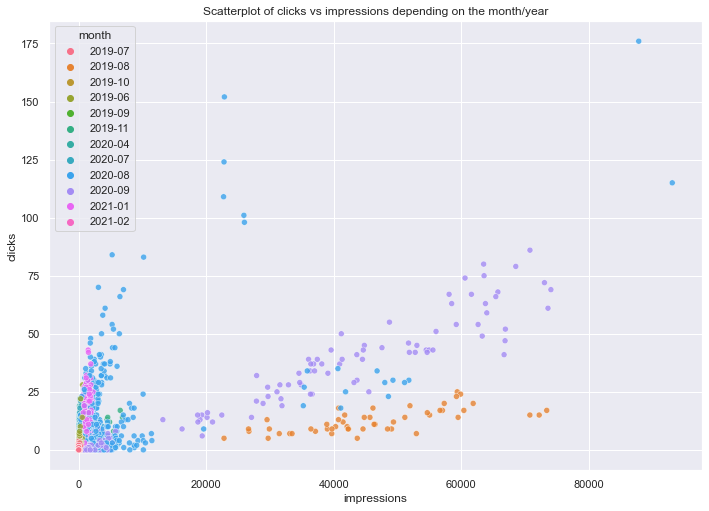

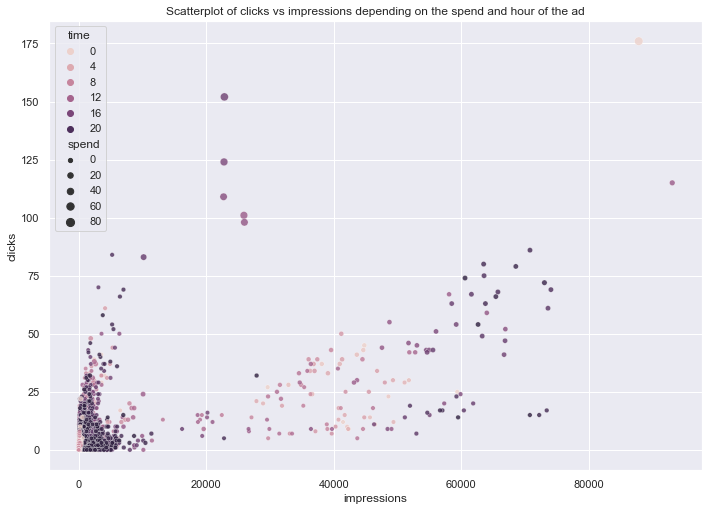

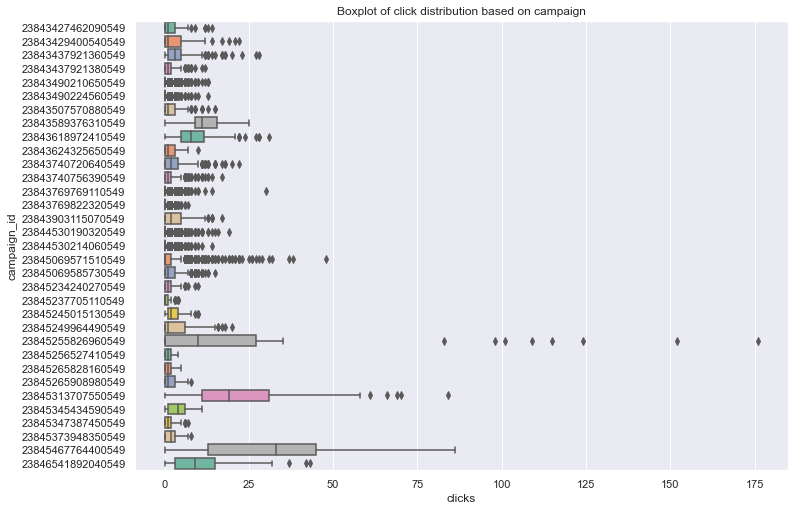

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(data=df, x='impressions', y='clicks', hue='month', alpha = 0.8)
g.set_title('Scatterplot of clicks vs impressions depending on the month/year')
plt.show()

s = sns.scatterplot(data=df, x='impressions', y='clicks', size='spend', hue='time', alpha = 0.8)
s.set_title('Scatterplot of clicks vs impressions depending on the spend and hour of the ad')
plt.show()

f = sns.boxplot(x=df["clicks"], y=df['campaign_id'], palette="Set2")
f.set_title('Boxplot of click distribution based on campaign')
plt.show()

## 4) ML model


> Given the data and business goal described above, which algorithms could we,
in theory, use in order to optimize those campaigns in the future? What would
be the advantages and disadvantages of those different approaches with this
given business case & data. Please reason your answers based on the data
given. A basic EDA could help.

As a beginner, my first instinct is to try different supervised learning algorithms and compare their performance based on the metrics I need (click-rate and purchase-rate). Regression models like Linear Regression and Decision trees are relatively fast but not very accurate. Since the dataset is sufficiently large but with low number of viable features, I'd go for low bias/high variance algorithms like KNN or Decision trees. 

> Lets assume we want to build a prediction model which uses the information of
the first 24 hours of each ad to predict its future performance.
a. Please state two options how you would define a target metric for a
supervised learning approach. Remember that we want to optimize our
system on identifying well performing ads in comparison to poorly
performing ads. State the pros and cons of each definition in terms of
model evaluation, complexity and business goals.
b. Please create and train a prediction model (baseline-model). How do
you evaluate its performance?

Taking the 24 hour parameter mentioned above, I reshaped the dataframe and got 14040 rows. This means that a large portion of the ads (476 out of 1061) of ads have been on for less than a day and cannot by definition be used to train a new model. <br>
a) The two possible target metrics are click per impression (CTR) or purchase per click (PPC?). The second metric could have an advantage as it takes one extra feature (clicks) into training. However, since the number of purchases are extremely low, it is hard not to get high bias in an asymmetric dataset. It will also make the model a bit more complicated. Both metrics are important for business goals, since to my understanding clicks already return some revenue. <br>
b) The performance of the Decision Tree is not too bad if we look at both the precision (tp / tp + fp) and recall (tp / tp + fn) results. In this sense, my understanding of the target metrics is as follows:
- True positives (TP): money gained (impressions paid for that were clicked on).
- False positives (FP): money lost (impressions that were paid for, but not clicked).
- True negatives (TN): money saved (no click predicted so no impressions bought).
- False negatives (FN): money lost out on (no click predicted, but would have been actual
click in reality). <br>


In [8]:
# Getting unique ads, looping over the first 24 observations for each ad then concat-ing into a new df 
# there might be a more efficient way to do this that I didn't think of) 

unique_ads = df.ad_id.unique()
ad_dic = {}

for ad in unique_ads:
    new_df = df.groupby('ad_id').get_group(ad).reset_index()
    new_df = new_df.nsmallest(24, 'date')
    if len(new_df) > 23:
        ad_dic[ad] = new_df

df24 = pd.concat(ad_dic.values(), ignore_index=True)
df24.clicks.value_counts()

# 17% of ads have been clicked on
print(len(df24.query('clicks > 0')) / len(df24))
display(df24.head())

0.17393162393162392


,index,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase,CTR,month
0,4505,23843490210650549,23843490222550549,2019-07-15,18,0.00,1,0,0.0,0.0,2019-07
1,4993,23843490210650549,23843490222550549,2019-07-15,19,0.04,1,0,0.0,0.0,2019-07
2,7038,23843490210650549,23843490222550549,2019-07-15,23,0.00,1,0,0.0,0.0,2019-07
3,364,23843490210650549,23843490222550549,2019-07-16,8,0.02,2,0,0.0,0.0,2019-07
4,839,23843490210650549,23843490222550549,2019-07-16,9,0.08,6,0,0.0,0.0,2019-07


In [9]:
# Standardize high variance features to control their dominance
num_df24 = df24.loc[:, ['spend', 'impressions']]
median = num_df24.var().median()
print("Median of variance before standardization:", median)

change_cols = num_df24.columns[num_df24.var() > num_df24.var().median()].tolist()
num_df24[change_cols] = num_df24[change_cols].apply(lambda x: np.log(x))
print("Median of variance after standardization:", num_df24.var().median())

# Define X with the goal is to predict clicks based on [campaign_id, ad_id, spend, impressions, time]

X = df24.loc[:, ['campaign_id', 'ad_id', 'spend', 'impressions', 'time']]
y = df24.loc[:,'clicks']

# Make sure all is well-scaled
X_scaled = StandardScaler().fit_transform(X[['spend', 'impressions']])

# Convert category to hash integers 
categorical_cols = X.select_dtypes(include = ['category']).columns.tolist()
X['campaign_id'] = X['campaign_id'].apply(lambda x: hash(x))
X['ad_id'] = X['ad_id'].apply(lambda x: hash(x))

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

Median of variance before standardization: 2991431.4320795718
Median of variance after standardization: 1.6067950919277791


In [10]:
# Iterate over different levels of max depth
for max_depth_val in [2, 3, 5, 10, 15, 20]:
  # Create and fit model
    clf = DecisionTreeClassifier(max_depth = max_depth_val)
    print("Evaluating tree with max_depth = %s" %(max_depth_val))
    y_pred = clf.fit(X_train, y_train).predict(X_test) 
  
  # Evaluate confusion matrix, precision, recall
    prec = precision_score(y_test, y_pred, average = 'weighted', zero_division =0)
    recall = recall_score(y_test, y_pred, average = 'weighted', zero_division =0)
    print("Precision: %s, Recall: %s" %(prec, recall))

Evaluating tree with max_depth = 2
Precision: 0.7338516345651278, Recall: 0.8228312473025464
Evaluating tree with max_depth = 3
Precision: 0.7338516345651278, Recall: 0.8228312473025464
Evaluating tree with max_depth = 5
Precision: 0.7299881498068728, Recall: 0.8215364695727233
Evaluating tree with max_depth = 10
Precision: 0.7599595920460022, Recall: 0.807078118256366
Evaluating tree with max_depth = 15
Precision: 0.7573529286003817, Recall: 0.7829089339663358
Evaluating tree with max_depth = 20
Precision: 0.7578680979848297, Recall: 0.7701769529564092


Precision scores: [0.76718837 0.77428561 0.7500146  0.77567536]
Recall scores: [0.81377551 0.8125     0.80433858 0.82092726]


Non-predicted click values are: {34, 41, 15, 16, 17, 22, 24, 59}


Feature: 0, Score: 0.04101
Feature: 1, Score: 0.05367
Feature: 2, Score: 0.21804
Feature: 3, Score: 0.54014
Feature: 4, Score: 0.14713


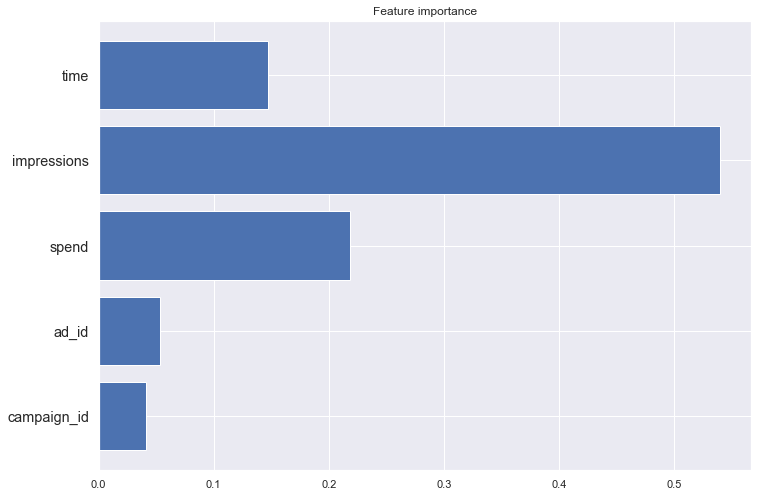

[0.04101034 0.05367471 0.21803821 0.5401437  0.14713305]


In [11]:
warnings.filterwarnings("ignore")

# Create model based on the best results of max_depth
clf = DecisionTreeClassifier(max_depth = 10)

# Fit the model to the training data and predict the test labels

y_pred = clf.fit(X_train, y_train).predict(X_test)

# Set up k-fold for cross validation
k_fold = KFold(n_splits = 4, random_state = 21, shuffle=True)

# Evaluate precision and recall for each fold
precision = cross_val_score(clf, X_train, y_train, cv = k_fold, scoring = 'precision_weighted')
recall = cross_val_score(clf, X_train, y_train, cv = k_fold, scoring = 'recall_weighted')
print("Precision scores: %s" %(precision)) 
print("Recall scores: %s" %(recall))
print('\n')

# the click values of {34, 41, 15, 16, 22, 24, 59} have never been predicted in y_pred; That explains the (ignored) warnings
print("Non-predicted click values are: %s" %(set(y_test) - set(y_pred)))
print('\n')

# get importance
importance = clf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks= np.arange(5) ,labels=X.columns, fontsize='large')
plt.title('Feature importance')
plt.show()

print(clf.feature_importances_)

## 5) Conclusion

> Do you think the approach taken will help our business goal and increase overal
campaign performance?
If not so, what are the prohibiting factors for a successful setup? What needs to be
improved?
What other sources of data, or features come into your mind, which could help improve
the models?

In general, I don't believe there are many useful features for predictions in this dataset. To learn from campaign_id or ad_id, it need no machine learning model but a simple dashboard with realtime data (see below for the pivoted table example). The above 'feature importance' chart shows that impressions are the best predictor, but I am still not sure how impressions are exactly allocated and how much 'chance' there is in some ads being seen more than others. <br><br>
In retrospect, I realize the target metric of clicks is not suitable as most click numbers that are above 1 are rare events. It would have been better to make clicks a binary variable of 0 (non-clicked) and 1 (clicked) as a baseline model. This would give more learning power to a classification model even though the asymmetry between clicks and non-clicks will remain high. For better results with similar approach, a Random Forest or XGBoost models can be tried. Alternatively, we can use the CTR metric for prediction in a regression model like linear regression. For the purchase predicitons, I believe we need more features or more balanced dataset with more successful purchases.<br>

Other features that come to my mind that would improve the model are:

 - size, shape, color and placement of the ad
 - product advertised or type of event
 - info about the target audience
 - device of the clicker (e.g. PC, iPhone or Android user)

Several techniques are suggested [here](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html) to handle imbalanced data, which might be worth looking at.


In [12]:
# this new dataframe can be used as part of a Dashboard

#df.groupby(['campaign_id', 'month'])['spend', 'clicks', 'purchase'].sum()
pivoted_df=df.pivot_table(index='campaign_id', values=['spend', 'impressions', 'clicks', 'purchase'], aggfunc=['sum', 'size'])
pivoted_df.columns = ['number_of_clicks', 'number_of_impressions', 'number_of_purchases', 'total_campaign_spend', 'numbers_of_ads_hours']
pivoted_df['campaign_CTR'] = pivoted_df.number_of_clicks / pivoted_df.number_of_impressions
pivoted_df['total_purchase_by_click'] = pivoted_df.number_of_purchases / pivoted_df.number_of_clicks
display(pivoted_df.dropna().sort_values('total_purchase_by_click', ascending=False).head(10))


,number_of_clicks,number_of_impressions,number_of_purchases,total_campaign_spend,numbers_of_ads_hours,campaign_CTR,total_purchase_by_click
campaign_id,,,,,,,
23843490224560549,880,83999,53.0,511.939997,8168,0.010476,0.060227
23843490210650549,2912,184445,121.0,1731.220009,12204,0.015788,0.041552
23843507570880549,716,39842,25.0,479.240000,365,0.017971,0.034916
23843624325650549,379,65800,13.0,179.960000,214,0.005760,0.034301
23845069585730549,2673,98479,86.0,902.780001,1430,0.027143,0.032174
23843769769110549,2577,178079,45.0,1233.700000,7614,0.014471,0.017462
23843740720640549,3073,118754,43.0,1116.489999,1171,0.025877,0.013993
23845234240270549,991,2024639,12.0,1780.380000,1028,0.000489,0.012109
23843437921380549,583,80146,7.0,782.540000,462,0.007274,0.012007
